In [38]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [19]:
os.chdir('/Users/hungduong/Documents/MSBA UofU/MSBA 4th/IS 6813')


customer = pd.read_csv("Copy of customer.csv")
# cutoff = pd.read_csv("Copy of cutoff_times.csv")
# ga = pd.read_csv("Copy of google_analytics.csv")
material  = pd.read_csv("Copy of material.csv")
# hours  = pd.read_csv("Copy of operating_hours.csv")
# orders = pd.read_csv("Copy of orders.csv")
# sales = pd.read_csv("Copy of sales.csv")
# visit =  pd.read_csv("visit_plan.csv")
abandon = pd.read_csv("final_with_ga.csv")


# EDA

What is abandon table? abandon table have each rows as a unique combination of CUSTOMER_ID and ANCHOR_DATE, having cart activities during that window; if not that specific window will be excluded.

In [7]:
pd.set_option('display.max_columns', None)
abandon[abandon['CUSTOMER_ID']==500245797]



,CUSTOMER_ID,ANCHOR_DATE,SALES_OFFICE,SALES_OFFICE_DESC,DISTRIBUTION_MODE,SHIPPING_CONDITIONS_DESC,FREQUENCY_CLEAN,DISTRIBUTION_MODE_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,NEXT_ANCHOR_SAME_WD,CREATED_DATE_UTC,MATERIAL_ID,ORDER_QUANTITY,ORDER_TYPE,CREATED_DATE_EST,ORDER_EXISTS,added_items,num_items_added,purchases,button_clicks,total_events,ABANDONED_CART
29,500245797,2024-11-29,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Friday,28,5:00:00 PM,2024-12-27,2024-12-04 20:37:01+00:00,150924.0,1.0,MYCOKE360,2024-12-04,1,15,555,1,40,179,0
30,500245797,2024-12-27,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Friday,28,5:00:00 PM,2025-01-24,2025-01-08 19:10:28+00:00,138331.0,1.0,MYCOKE360,2025-01-08,1,19,703,0,60,349,1
31,500245797,2025-01-24,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Friday,28,5:00:00 PM,2025-02-21,2025-02-18 22:50:25+00:00,150917.0,2.0,MYCOKE360,2025-02-18,1,19,703,1,59,180,0
32,500245797,2025-02-21,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Friday,28,5:00:00 PM,2025-03-21,2025-03-19 22:44:15+00:00,150917.0,1.0,MYCOKE360,2025-03-19,1,12,444,1,39,105,0
33,500245797,2025-04-18,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Friday,28,5:00:00 PM,2025-05-16,2025-04-23 20:30:32+00:00,150922.0,2.0,MYCOKE360,2025-04-23,1,21,778,0,74,217,1


In [8]:
# Data missingness
print(len(abandon))
abandon.isna().sum()

19492


CUSTOMER_ID                     0
ANCHOR_DATE                     0
SALES_OFFICE                    0
SALES_OFFICE_DESC               0
DISTRIBUTION_MODE               0
SHIPPING_CONDITIONS_DESC        0
FREQUENCY_CLEAN             13107
DISTRIBUTION_MODE_DESC          0
WEEK_DAY_OF_ANCHOR_DATE         0
WINDOW_FREQUENCY                0
CUTOFFTIME__C                   0
NEXT_ANCHOR_SAME_WD             0
CREATED_DATE_UTC             2853
MATERIAL_ID                  2853
ORDER_QUANTITY               2853
ORDER_TYPE                   2853
CREATED_DATE_EST             2853
ORDER_EXISTS                    0
added_items                     0
num_items_added                 0
purchases                       0
button_clicks                   0
total_events                    0
ABANDONED_CART                  0
dtype: int64

The cart abandon rate is 15.15%


Text(0.5, 1.0, 'The distribution of abandon cart and not')

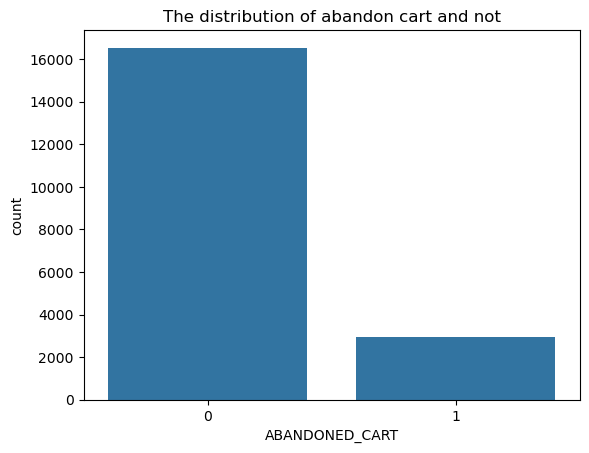

In [9]:
# What is the abandon rate
print(f'The cart abandon rate is {abandon['ABANDONED_CART'].mean()*100:.2f}%')

sns.countplot(x = abandon['ABANDONED_CART'])
plt.title('The distribution of abandon cart and not')


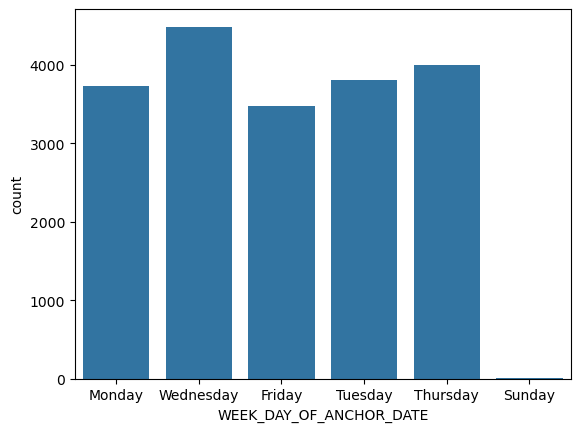

In [10]:
# Which day of the week do customes tend to set their anchor date in
sns.countplot(x='WEEK_DAY_OF_ANCHOR_DATE', data=abandon)
plt.show()

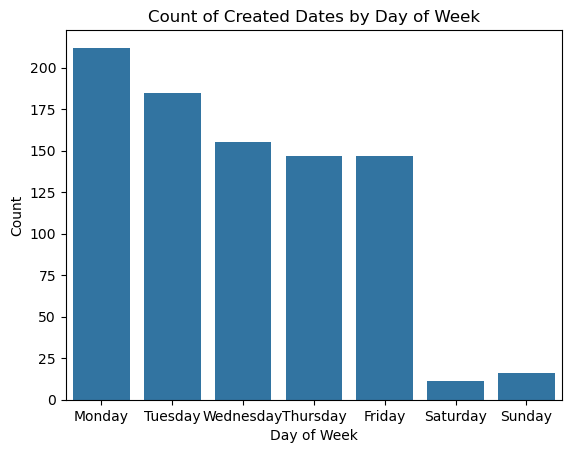

In [11]:
# Day of the week customer usually purchase 
# Convert the 'CREATED_DATE_UTC' column to datetime if it isn't already
abandon['CREATED_DATE_UTC'] = pd.to_datetime(abandon['CREATED_DATE_UTC'])

# Extract day of the week (Monday=0, Sunday=6)
abandon['Day_of_week_last_event'] = abandon['CREATED_DATE_UTC'].dt.day_name()

# Plot the counts of each day
ax = sns.countplot(x='Day_of_week_last_event', data=abandon[abandon['ABANDONED_CART']==1], order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Count of Created Dates by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.show()

Mondays and earlier weekdays seems to be the days where businesses tends to prep their stocks

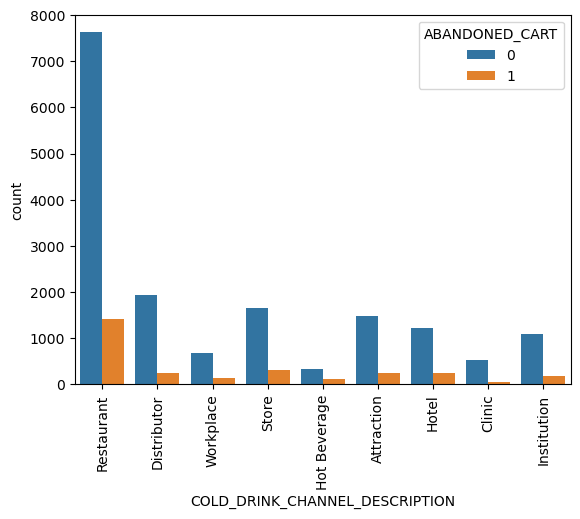

In [12]:
abandon_customer = pd.merge(abandon, customer, left_on='CUSTOMER_ID', right_on='CUSTOMER_NUMBER', how='left')

sns.countplot(x='COLD_DRINK_CHANNEL_DESCRIPTION',hue='ABANDONED_CART', data=abandon_customer)
plt.xticks(rotation=90)
plt.show()

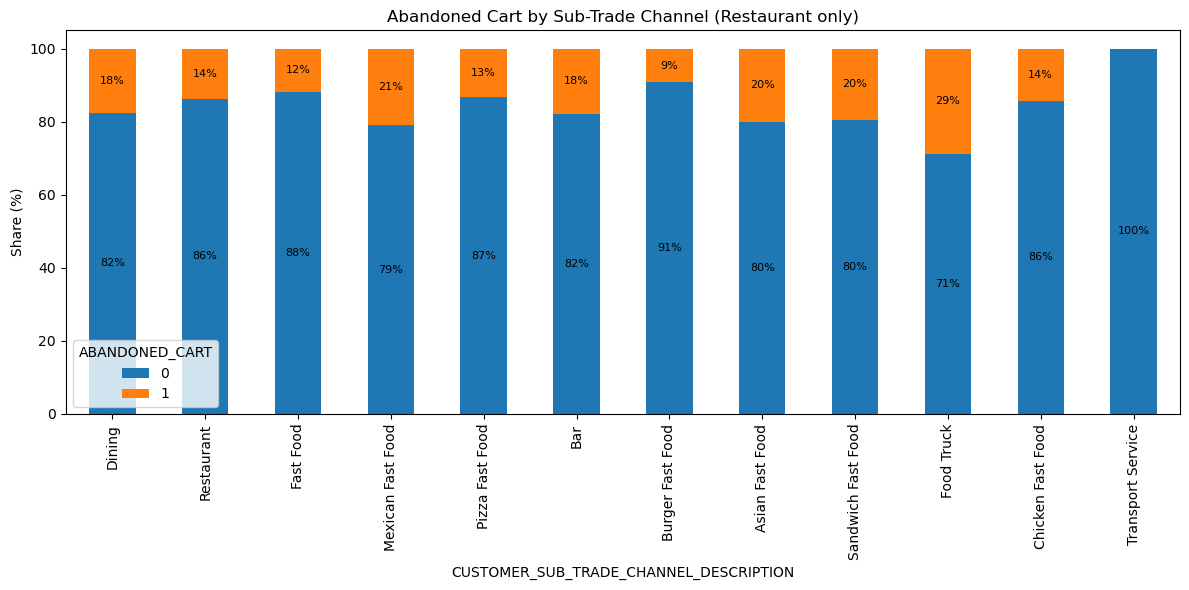

In [39]:
# Which type of restaurant?

# Filter to Restaurant
sub = (
    abandon_customer
    .loc[abandon_customer['COLD_DRINK_CHANNEL_DESCRIPTION'].eq('Restaurant')]
    .copy()
)

# Clean columns
sub['CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION'] = (
    sub['CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION'].fillna('Unknown')
)
sub['ABANDONED_CART'] = pd.to_numeric(sub['ABANDONED_CART'], errors='coerce').fillna(0).astype(int)

# Cross-tab (counts) by sub-trade channel x abandoned flag
ct = pd.crosstab(
    sub['CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION'],
    sub['ABANDONED_CART']
)

# Optional: order categories by total count (descending) to make the plot clearer
ct = ct.loc[ct.sum(axis=1).sort_values(ascending=False).index]

# Proportions per sub-trade channel (row-wise 100%)
prop = (ct.div(ct.sum(axis=1).replace(0, np.nan), axis=0) * 100).fillna(0)

# Plot 100% stacked bar
ax = prop.plot(kind='bar', stacked=True, figsize=(12, 6))
ax.set_ylabel('Share (%)')
ax.set_title('Abandoned Cart by Sub-Trade Channel (Restaurant only)')
ax.legend(title='ABANDONED_CART', loc='best')
plt.xticks(rotation=90)

# Add % labels inside bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        x = p.get_x() + p.get_width()/2
        y = p.get_y() + height/2
        ax.text(x, y, f"{height:.0f}%", ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

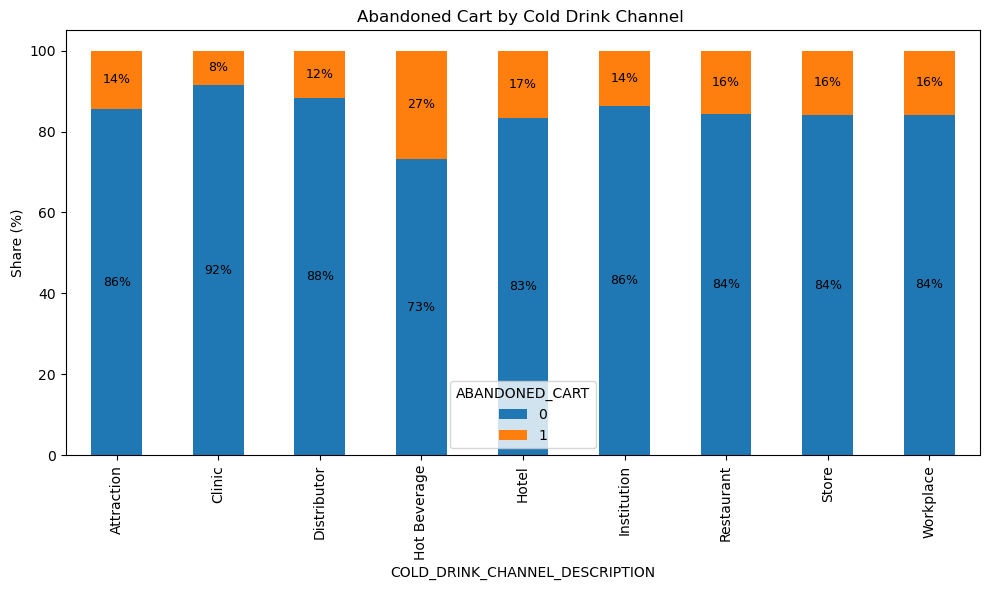

In [13]:
# cross-tab for counts
ct = pd.crosstab(
    abandon_customer['COLD_DRINK_CHANNEL_DESCRIPTION'],
    abandon_customer['ABANDONED_CART']
).sort_index()

# proportions per channel
prop = ct.div(ct.sum(axis=1), axis=0) * 100

ax = prop.plot(kind='bar', stacked=True, figsize=(10,6))
ax.set_ylabel('Share (%)')
ax.set_title('Abandoned Cart by Cold Drink Channel ')
ax.legend(title='ABANDONED_CART', loc='best')

# optional: add % labels inside bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height > 0:
        x = p.get_x() + width/2
        y = p.get_y() + height/2
        ax.text(x, y, f"{height:.0f}%", ha='center', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# ignore from here

In [24]:
orders.head()

,CUSTOMER_ID,CREATED_DATE_EST,CREATED_DATE_UTC,MATERIAL_ID,ORDER_QUANTITY,ORDER_TYPE,PLANT_ID
0,600265510,2025-01-10,2025-01-10 22:40:25+00:00,152965.0,1.0,CALL CENTER,G267
1,600584506,2024-11-22,2024-11-22 17:34:30+00:00,156127.0,1.0,SALES REP,G221
2,600686120,2024-06-04,2024-06-05 00:29:33+00:00,103886.0,1.0,SALES REP,G291
3,501087671,2024-12-03,2024-12-03 18:14:23+00:00,134926.0,2.0,SALES REP,G163
4,501680332,2025-03-31,2025-03-31 22:33:07+00:00,152196.0,1.0,SALES REP,G221


In [23]:
orders['CREATED_DATE_UTC'] = pd.to_datetime(
    orders['CREATED_DATE_UTC'],
    utc=True,
    errors='coerce'
)
orders['CREATED_DATE_UTC'] = orders['CREATED_DATE_UTC'].dt.floor('s')


In [34]:
abandon['ANCHOR_DATE'] = pd.to_datetime(
    abandon['ANCHOR_DATE'].astype(str) + ' ' + abandon['CUTOFFTIME__C'].astype(str),
    errors='coerce'  # bad rows -> NaT
)

abandon['NEXT_ANCHOR_SAME_WD'] = pd.to_datetime(
    abandon['NEXT_ANCHOR_SAME_WD'].astype(str) + ' ' + abandon['CUTOFFTIME__C'].astype(str),
    errors='coerce'  # bad rows -> NaT
)

abandon[abandon['CUSTOMER_ID']==500245738]


/var/folders/hd/fbf93pws5pn1ycb22tw5k1240000gn/T/ipykernel_91633/918737483.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  abandon['ANCHOR_DATE'] = pd.to_datetime(
/var/folders/hd/fbf93pws5pn1ycb22tw5k1240000gn/T/ipykernel_91633/918737483.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  abandon['NEXT_ANCHOR_SAME_WD'] = pd.to_datetime(


,CUSTOMER_ID,ANCHOR_DATE,SALES_OFFICE,SALES_OFFICE_DESC,DISTRIBUTION_MODE,SHIPPING_CONDITIONS_DESC,FREQUENCY_CLEAN,DISTRIBUTION_MODE_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,NEXT_ANCHOR_SAME_WD,CREATED_DATE_UTC,MATERIAL_ID,ORDER_QUANTITY,ORDER_TYPE,CREATED_DATE_EST,ORDER_EXISTS,added_items,num_items_added,purchases,button_clicks,total_events,ABANDONED_CART
4,500245738,2024-11-20 17:00:00,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Wednesday,7,5:00:00 PM,2024-11-27 17:00:00,2024-11-22 18:46:16+00:00,158779.0,1.0,MYCOKE360,2024-11-22,1,1,397,1,1,27,0
5,500245738,2024-11-27 17:00:00,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Wednesday,7,5:00:00 PM,2024-12-04 17:00:00,2024-11-28 02:46:16+00:00,153293.0,1.0,MYCOKE360,2024-11-27,1,1,865,1,0,18,0
6,500245738,2024-12-04 17:00:00,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Wednesday,7,5:00:00 PM,2024-12-11 17:00:00,2024-12-06 21:44:24+00:00,121750.0,1.0,MYCOKE360,2024-12-06,1,3,1335,2,3,53,0
7,500245738,2024-12-11 17:00:00,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Wednesday,7,5:00:00 PM,2024-12-18 17:00:00,2024-12-13 01:44:02+00:00,115586.0,2.0,MYCOKE360,2024-12-12,1,1,757,1,0,19,0
8,500245738,2024-12-18 17:00:00,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Wednesday,7,5:00:00 PM,2024-12-25 17:00:00,2024-12-23 22:36:08+00:00,156082.0,1.0,MYCOKE360,2024-12-23,1,2,902,1,2,26,0
9,500245738,2025-01-08 17:00:00,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Wednesday,7,5:00:00 PM,2025-01-15 17:00:00,2025-01-13 22:02:05+00:00,115586.0,3.0,MYCOKE360,2025-01-13,1,2,1298,2,6,82,0
10,500245738,2025-01-15 17:00:00,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Wednesday,7,5:00:00 PM,2025-01-22 17:00:00,2025-01-20 22:42:02+00:00,154914.0,1.0,MYCOKE360,2025-01-20,1,1,721,1,0,21,0
11,500245738,2025-01-22 17:00:00,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Wednesday,7,5:00:00 PM,2025-01-29 17:00:00,2025-01-27 23:20:23+00:00,115586.0,2.0,MYCOKE360,2025-01-27,1,1,901,1,4,42,0
12,500245738,2025-01-29 17:00:00,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Wednesday,7,5:00:00 PM,2025-02-05 17:00:00,2025-02-03 22:10:27+00:00,102604.0,1.0,MYCOKE360,2025-02-03,1,2,1010,1,1,31,0
13,500245738,2025-02-05 17:00:00,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Wednesday,7,5:00:00 PM,2025-02-12 17:00:00,2025-02-10 23:40:20+00:00,156090.0,2.0,MYCOKE360,2025-02-10,1,1,829,1,0,18,0


In [43]:
# Dtypes already good:
# orders['CREATED_DATE_UTC'] -> datetime64[ns, UTC]
# ab['START_UTC'], ab['END_UTC'] -> datetime64[ns, UTC]
orders['CUSTOMER_ID'] = orders['CUSTOMER_ID'].astype(str)
ab['CUSTOMER_ID']     = ab['CUSTOMER_ID'].astype(str)

# Drop rows with null join keys
left  = orders.dropna(subset=['CREATED_DATE_UTC']).copy()
right = ab.dropna(subset=['START_UTC','END_UTC']).copy()

# De-dupe right on (CUSTOMER_ID, START_UTC) just in case
right = (right
         .sort_values(['CUSTOMER_ID','START_UTC'], kind='mergesort')
         .drop_duplicates(['CUSTOMER_ID','START_UTC'], keep='last'))

# 🔑 Sort by the time keys FIRST (global monotonic), then by CUSTOMER_ID (stable)
left  = left.sort_values(['CREATED_DATE_UTC','CUSTOMER_ID'], kind='mergesort').reset_index(drop=True)
right = right.sort_values(['START_UTC','CUSTOMER_ID'],       kind='mergesort').reset_index(drop=True)

# Optional sanity checks
# assert left['CREATED_DATE_UTC'].is_monotonic_increasing
# assert right['START_UTC'].is_monotonic_increasing

matched = pd.merge_asof(
    left=left,
    right=right[['CUSTOMER_ID','START_UTC','END_UTC']],
    by='CUSTOMER_ID',
    left_on='CREATED_DATE_UTC',
    right_on='START_UTC',
    direction='backward',
    allow_exact_matches=True
)

# Keep only orders inside [START_UTC, END_UTC)
matched = matched[matched['CREATED_DATE_UTC'] < matched['END_UTC']]

# Bring back full abandon row if needed
out = matched.merge(
    right,
    on=['CUSTOMER_ID','START_UTC','END_UTC'],
    how='left',
    suffixes=('_order','_abandon')
)


In [44]:
pieces = []
for cid, g in orders.groupby(orders['CUSTOMER_ID'].astype(str)):
    r = ab[ab['CUSTOMER_ID'].astype(str) == cid]
    if r.empty:
        continue
    g2 = g.dropna(subset=['CREATED_DATE_UTC']).sort_values('CREATED_DATE_UTC')
    r2 = (r.dropna(subset=['START_UTC'])
            .sort_values('START_UTC')
            .drop_duplicates('START_UTC', keep='last'))

    m = pd.merge_asof(
        g2, r2[['START_UTC','END_UTC']],
        left_on='CREATED_DATE_UTC', right_on='START_UTC',
        direction='backward', allow_exact_matches=True
    )
    m = m[m['CREATED_DATE_UTC'] < m['END_UTC']]
    m['CUSTOMER_ID'] = cid  # if it was the index in groupby
    pieces.append(m)

out = pd.concat(pieces, ignore_index=True)


In [46]:
out[out['CUSTOMER_ID']==500245738]

,CUSTOMER_ID,CREATED_DATE_EST,CREATED_DATE_UTC,MATERIAL_ID,ORDER_QUANTITY,ORDER_TYPE,PLANT_ID,START_UTC,END_UTC


In [47]:
out

,CUSTOMER_ID,CREATED_DATE_EST,CREATED_DATE_UTC,MATERIAL_ID,ORDER_QUANTITY,ORDER_TYPE,PLANT_ID,START_UTC,END_UTC
0,500245738,2024-11-22,2024-11-22 18:46:16+00:00,129254.0,2.0,MYCOKE360,G111,2024-11-21 00:00:00+00:00,2024-11-28 00:00:00+00:00
1,500245738,2024-11-22,2024-11-22 18:46:16+00:00,156090.0,1.0,MYCOKE360,G111,2024-11-21 00:00:00+00:00,2024-11-28 00:00:00+00:00
2,500245738,2024-11-22,2024-11-22 18:46:16+00:00,115586.0,1.0,MYCOKE360,G111,2024-11-21 00:00:00+00:00,2024-11-28 00:00:00+00:00
3,500245738,2024-11-22,2024-11-22 18:46:16+00:00,151817.0,1.0,MYCOKE360,G111,2024-11-21 00:00:00+00:00,2024-11-28 00:00:00+00:00
4,500245738,2024-11-22,2024-11-22 18:46:16+00:00,154900.0,1.0,MYCOKE360,G111,2024-11-21 00:00:00+00:00,2024-11-28 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...
184670,600975280,2025-05-06,2025-05-06 22:50:17+00:00,103029.0,2.0,MYCOKE360,G282,2025-04-19 00:00:00+00:00,2025-05-17 00:00:00+00:00
184671,600975280,2025-05-06,2025-05-06 22:50:17+00:00,133129.0,1.0,MYCOKE360,G282,2025-04-19 00:00:00+00:00,2025-05-17 00:00:00+00:00
184672,600975280,2025-05-06,2025-05-06 22:50:17+00:00,412547.0,1.0,MYCOKE360,G282,2025-04-19 00:00:00+00:00,2025-05-17 00:00:00+00:00
184673,600975280,2025-05-06,2025-05-06 22:50:17+00:00,152196.0,1.0,MYCOKE360,G282,2025-04-19 00:00:00+00:00,2025-05-17 00:00:00+00:00


In [66]:
sales.head()

,CUSTOMER_ID,POSTING_DATE,MATERIAL_ID,GROSS_PROFIT_DEAD_NET,PHYSICAL_VOLUME,NSI,NSI_DEAD_NET,GROSS_PROFIT
0,501473438,2024-06-10,123159,53.60,8.0,111.04,111.04,53.60
1,501473438,2024-06-10,115584,21.76,4.0,51.12,51.12,21.76
2,501502460,2024-06-10,103996,-0.89,2.0,210.80,210.80,-0.89
3,501168843,2024-06-10,156091,10.20,2.0,30.50,30.50,10.20
4,501583464,2024-06-10,119827,42.15,4.0,98.40,88.40,52.15


In [60]:
sales_abandon = pd.merge(abandon, sales, on='CUSTOMER_ID',how='left')

In [61]:
sales_abandon.head()

,CUSTOMER_ID,ANCHOR_DATE,SALES_OFFICE,SALES_OFFICE_DESC,DISTRIBUTION_MODE,SHIPPING_CONDITIONS_DESC,FREQUENCY_CLEAN,DISTRIBUTION_MODE_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,CUTOFFTIME__C,NEXT_ANCHOR_SAME_WD,CREATED_DATE_UTC,MATERIAL_ID_x,ORDER_QUANTITY,ORDER_TYPE,CREATED_DATE_EST,ORDER_EXISTS,added_items,num_items_added,purchases,button_clicks,total_events,ABANDONED_CART,Day_of_week_last_event,POSTING_DATE,MATERIAL_ID_y,GROSS_PROFIT_DEAD_NET,PHYSICAL_VOLUME,NSI,NSI_DEAD_NET,GROSS_PROFIT
0,500245685,2025-02-17,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Monday,7,5:00:00 PM,2025-02-24,NaT,NaN,NaN,NaN,NaN,0,1,37,1,41,261,0,NaN,2024-08-02,138334.0,65.58,2.0,225.68,197.68,14.88
1,500245685,2025-02-17,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Monday,7,5:00:00 PM,2025-02-24,NaT,NaN,NaN,NaN,NaN,0,1,37,1,41,261,0,NaN,2024-08-02,121751.0,63.47,3.0,105.00,93.00,75.47
2,500245685,2025-02-17,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Monday,7,5:00:00 PM,2025-02-24,NaT,NaN,NaN,NaN,NaN,0,1,37,1,41,261,0,NaN,2024-08-02,117119.0,33.95,2.0,118.50,104.50,8.60
3,500245685,2025-02-17,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Monday,7,5:00:00 PM,2025-02-24,NaT,NaN,NaN,NaN,NaN,0,1,37,1,41,261,0,NaN,2024-07-12,110802.0,62.52,3.0,338.52,296.52,22.32
4,500245685,2025-02-17,G111,"Draper, UT",OF,48 Hours,NaN,OFS,Monday,7,5:00:00 PM,2025-02-24,NaT,NaN,NaN,NaN,NaN,0,1,37,1,41,261,0,NaN,2024-07-12,122151.0,50.93,3.0,177.75,156.75,12.90


In [62]:
# aggregation: sum of sales amount by CUSTOMER_ID
sales_abandon_agg = sales_abandon.groupby(['CUSTOMER_ID','POSTING_DATE']).agg({
    'NSI_DEAD_NET': 'mean',   
    'PHYSICAL_VOLUME': 'mean', 
    'button_clicks': 'sum',
           
    # add more aggregations as needed
})


In [65]:
sales_abandon_agg.head(20)

NSI_DEAD_NET  PHYSICAL_VOLUME  button_clicks
CUSTOMER_ID POSTING_DATE                                              
500245685   2024-06-14       53.000000         2.000000             63
            2024-07-12      256.585714         3.000000            441
            2024-08-02      114.014444         2.555556            567
            2024-08-16      148.370000         2.000000            378
            2024-08-30       53.000000         2.000000             63
500245738   2024-06-04       87.552000         3.000000            205
            2024-06-07       49.950000         2.400000            410
            2024-06-11       56.128889         2.333333            369
            2024-06-18       74.210625         3.437500            656
            2024-06-25       53.848889         2.444444            369
            2024-06-28       56.267500         2.250000            328
            2024-07-02       36.075000         2.500000             82
            2024-07-09       73.665455         2.545455            451
            2024-07-16       75.627692         2.769231            533
            2024-07-23       48.220000         2.000000            287
            2024-07-30       60.169167         2.333333            492
            2024-08-06       49.218182         2.181818            451
            2024-08-09      108.040000         3.000000            164
            2024-08-13       51.954286         2.500000            574
            2024-08-16       57.720000         4.000000             41